In [43]:
import numpy as np, os, geopandas as gpd, pandas as pd, osmnx as ox, pystac_client, planetary_computer, stackstac
from raster_tools import Raster, general
from raster_tools import raster
from owslib.wcs import WebCoverageService

In [44]:
import folium
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#Visualize the nf1 and sample locations
m=nf1p.explore(color='red',style_kwds=dict(fill=False,weight=5))
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m)
folium.LayerControl().add_to(m)
m

C:\Users\jshogland\AppData\Local\Temp\ipykernel_19640\4288319230.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  nfe=nf.explode()


In [45]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic

# Create definition for WCS download
def get_wcs_data(url,ply,service_name='mrlc_download__nlcd_tcc_conus_2021_v2021-4',out_prefix = 'tcc'):
    '''
    Extracts saves an image from a WCS given url, polygon boundary, and service name. Images are saved in the same location as the notebook.
    url = (string) path to wcs e.g. 'https://www.mrlc.gov/geoserver/mrlc_download/nlcd_tcc_conus_2021_v2021-4/wcs?'
    ply = (geoseries or geodataframe) of the study area
    service_name = (string) name of the service e.g. mrlc_download__nlcd_tcc_conus_2021_v2021-4
    out_prefix = (string) prefix used to save each image

    returns a Raster object
    '''
    wcs=WebCoverageService(url)
    tcc=wcs.contents[service_name]
    bbox=tuple(ply.total_bounds)
    subsets=[('X',bbox[0],bbox[2]),('Y',bbox[1],bbox[3])]
    rsp=wcs.getCoverage(identifier=[tcc.id],subsets=subsets,format='geotiff')
    outpath='./'+out_prefix+'.tif'
    with open(outpath,'wb') as file:
        file.write(rsp.read())

    return Raster(outpath)

In [46]:
#get stac data landsat data
if(not os.path.exists('ls82016.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2016-06-15/2016-06-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82016.tif')

#Load the Landsat raster
ls30s=Raster('ls82016.tif')

#get TCC data
if(not os.path.exists('cf1.tif')): #if the 2016 tree canopy cover file does not exits, download it
    url=r'https://www.mrlc.gov/geoserver/mrlc_download/nlcd_tcc_conus_2016_v2021-4/wcs?'
    sn='mrlc_download__nlcd_tcc_conus_2016_v2021-4'
    get_wcs_data(url=url,ply=nf1p,service_name=sn,out_prefix='cf1')


#Load the TCC raster
tcc_rs=Raster('cf1.tif')

In [47]:
import shapely, xarray as xr, numba as nb

#Create a random sample definition
def get_random_sample(bnd, n=1000):
    """
    produces a random sample given a geometry

    parameters:
    bnd = (GeoDataFrame or GeoSeries) project boundary
    n = number of observations

    returns: geodataframe of point locations

    """
    xmin, ymin, xmax, ymax = bnd.total_bounds
    xdif = xmax - xmin
    ydif = ymax - ymin
    pnts_lst = []
    ubnd=bnd.unary_union
    while len(pnts_lst) < n:
        x = (np.random.random() * xdif) + xmin
        y = (np.random.random() * ydif) + ymin
        pnt = shapely.geometry.Point([x, y])
        if pnt.intersects(ubnd):
            pnts_lst.append(pnt)

    dic = {"geometry": pnts_lst}
    gdf = gpd.GeoDataFrame(dic, crs=bnd.crs)

    return gdf

@nb.jit(nopython=True, nogil=True)
def _expand_pnts_for_kernel(isys,isxs,wsize):
    '''
    Extracts values for kernel cells. Cells indices falling on the boundary of the image are moved in one index value.
    isys=array of row index locations
    isxs=array of column index locations
    wsize=width of the kernel
    
    returns two new lists of index values kernel cell locations that can be used to extract coordinate from an xarray data array
    '''
    hw=int(wsize/2)
    isys2=np.zeros(isys.shape[0]*wsize*wsize,dtype='int32')
    isxs2=np.zeros(isxs.shape[0]*wsize*wsize,dtype='int32')
    cnt=0
    for r in range(isys.shape[0]):
        rvl=isys[r]
        cvl=isxs[r]
        rvlm=rvl-hw
        for r2 in range(wsize):
            nr=rvlm+r2
            cvlm=cvl-hw
            for c2 in range(wsize):
                nc=cvlm+c2
                isys2[cnt]=nr
                isxs2[cnt]=nc
                cnt+=1

    return isys2,isxs2

def create_sample(bndr,r_rs,pred_rs,n,wsize=1):
    '''
    Creates a simple random sample of locations given a boundary and n and extracts response and predictor variables values for those location and the cell surrounding those locations.
    bndr = GeoDataFrame or GeoSeries of the boundary
    r_rs = response Raster object to be sampled
    pred_rs= predictor Raster object to be sampled
    n = (integer) sample size
    wsize=(int) width of a square kernel in cells

    returns a GeoDataFrame of response and predictor cell values
    '''
    pnts=get_random_sample(bndr,n=n)
    xs=pnts.geometry.x
    ys=pnts.geometry.y
    rws=xs.shape[0]

    #get response values
    isys,isxs=r_rs.index(xs,ys)
    rsel=r_rs.xdata.isel(x=xr.DataArray(isxs,dims='loc'),y=xr.DataArray(isys,dims='loc'))
    rvls=pd.DataFrame(rsel.values.reshape((rws,1)),columns=['response'])

    #get predictor values
    isys,isxs=pred_rs.index(xs,ys)



    if(wsize>1):
        isys,isxs=_expand_pnts_for_kernel(isys.values,isxs.values,wsize)

    sel=pred_rs.xdata.isel(x=xr.DataArray(isxs,dims='loc'),y=xr.DataArray(isys,dims='loc'))
    pvls=sel.values.reshape((pred_rs.shape[0],rws,wsize*wsize))
    clms=sel.shape[0]*wsize*wsize
    pvls=pd.DataFrame(np.moveaxis(pvls,1,0).reshape(rws,clms),columns=['p' + str(sub) for sub in np.arange(clms)])

    df=pd.concat([pnts,pvls,rvls],axis=1)
    vls=df.dropna()#(df[df!=r_rs.null_value]).dropna()

    return vls

In [72]:
from hilbertcurve.hilbertcurve import HilbertCurve
from sklearn.decomposition import PCA
class hilbert:
    def __init__(self):
        self._p=None
        self._d=None
        self._hc = None
        self.s_arr = None
        self._pca=None
        self._min=None
        self._max=None

    @property
    def hilbert_mdl(self):
        return self._hc
    
    def _transform(self,X):
        if(self._pca is None):
            self._sd=np.std(X,axis=0)
            self._pca = PCA()
            x2=X/self._sd
            self._pca.fit(x2)
        else:
            x2=X/self._sd

        x3=self._pca.transform(x2)
        mlp=(2**self._p)-1
        if(self._min is None):
            self._min = np.min(x3)
            self._max = np.max(x3)

        vls=(((x3-self._min)/(self._max-self._min))*(mlp)).astype('uint32')
        vls[vls>mlp]=mlp
        vls[vls<0]=0
        return vls
    
    def fit(self,X,y,p=8):
        self._d=X.shape[1]
        self._p=p
        X2=self._transform(X)
        self._hc = HilbertCurve(self._p,self._d)
        hvls= np.array(self._hc.distances_from_points(X2)).astype('f8')
        tarr = pd.DataFrame([hvls,y],index=['hilb','resp']).T.sort_values('hilb')
        vls=tarr.groupby('hilb').mean().reset_index().values#.agg(['mean','count']).reset_index().values #
        self.s_arr = vls

    def predict(self,X):
        X2=self._transform(X)
        X3=np.array(self._hc.distances_from_points(X2)).astype('f8')
        return _impute_hc_f(X3,self.s_arr)
        
nb.jit(nopython=True, nogil=True)
def _get_hc(v,s_array):
    dic={}
    for r in range(s_array.shape[0]):
        ind,vl=s_array[r,:]
        if(v==ind):
            outvl=vl
            return outvl
        else:
            ind2=int(ind/2)
            if(ind2 in dic):
                j,k=dic[ind2]
                j+=vl
                k+=1
                dic[ind2] = [j,k]
            else:
                dic[ind2] = [vl,1]
    s_array2=np.zeros((len(dic),2))
    cnt=0
    for ky,vl in dic.items():
        s_array2[cnt,:]=[ky,vl[0]/vl[1]]
        cnt+=1

    outvl=_get_hc(int(v/2),s_array2)

    return outvl
                



    # ind=np.searchsorted(s_array[:,0],v)
    # if(ind>=s_array.shape[0]):
    #     outvl=s_array[-1,1]
    # elif(ind==0):
    #     outvl=s_array[0,1]
    # else:
    #     kyu,vlu=s_array[ind,:]
    #     if(kyu==v):
    #         outvl=vlu
    #     else:
    #         ind2=ind-1
    #         kyl,vll=s_array[ind2,:]
    #         # r=(vlu-vll)/(kyu-kyl)
    #         # outvl=vll+(v-kyl)*r
    #         dl=1/(v-kyl)
    #         du=1/(kyu-v)
    #         outvl=(vll*dl+vlu*du)/(dl+du)#((vll*dl*cl)+(vlu*du*cu))/((dl+du)*(cl+cu))
    #         #try using scale and bit math
    # 0return outvl..

nb.jit(nopython=True, nogil=True)
def _impute_hc_f(X,s_arr):
    rws=X.shape[0]
    out_arr=np.zeros((rws,1))
    for r in range(rws):
        v=X[r]
        outvl=_get_hc(v,s_arr)   
        out_arr[r]=outvl
    return out_arr



In [83]:
#samples
ksize=1
pnts2=create_sample(nf1p,r_rs=tcc_rs,pred_rs=ls30s,n=150,wsize=ksize)
pnts2['response']=pnts2['response']
pnts2.describe()


,p0,p1,p2,p3,p4,p5,p6,response
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.076937,0.071616,0.042639,0.240243,306.217868,0.199762,0.136394,27.326667
std,0.050793,0.035823,0.027583,0.049739,7.052619,0.089801,0.078152,25.293577
min,0.015682,0.020852,0.006415,0.119963,292.556840,0.053220,0.025115,0.000000
25%,0.033571,0.041704,0.018646,0.212012,300.568679,0.124376,0.070139,0.000000
50%,0.066956,0.069349,0.039497,0.239615,306.640791,0.206381,0.128652,23.500000
75%,0.104343,0.094862,0.060872,0.271192,311.085926,0.271694,0.188307,51.750000
max,0.220035,0.169545,0.114105,0.357370,320.567514,0.399913,0.319337,75.000000


Training Data
Response std = 25.234717999092936
RMSE = 0.0
train r2 = 1.0


<Axes: title={'center': 'Train Data Observed vs Predicted'}, xlabel='pred', ylabel='response'>

Response std = 25.57180689142454
RMSE = 14.297648544647123
val r2 = 0.7277225205418993


<Axes: title={'center': 'Validation Data Observed vs Predicted'}, xlabel='pred', ylabel='response'>

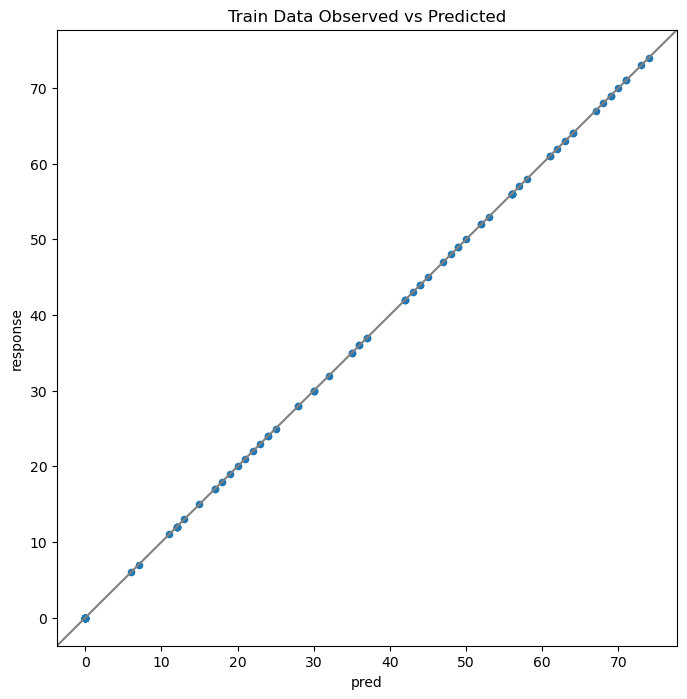

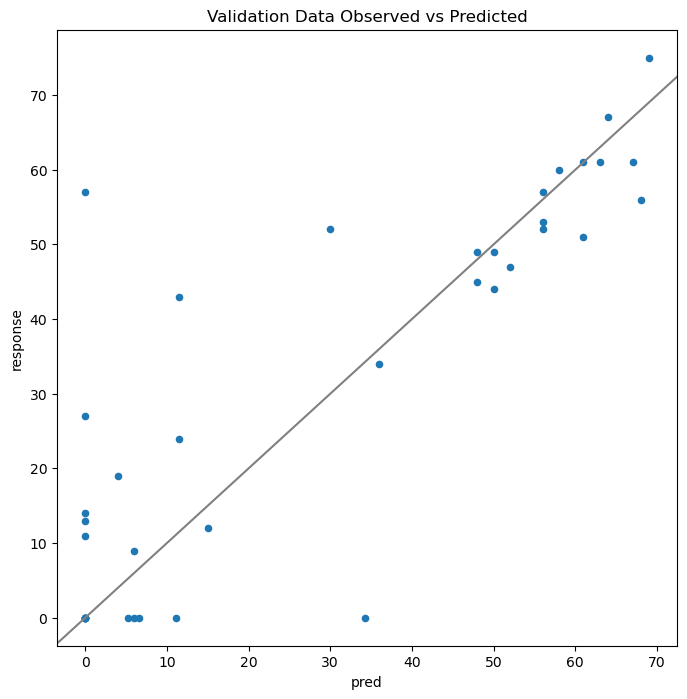

In [102]:
#training dataset
tdf_train = pnts2.sample(110)
tdf_val=pnts2.iloc[~pnts2.index.isin(tdf_train.index)].copy()
print('Training Data')
print('Response std =',tdf_train['response'].std())

#create hibert curve model
hc=hilbert()
pred_ls = pnts2.columns[1:-1]
resp=pnts2.columns[-1]
X=tdf_train[pred_ls].values
y=tdf_train[resp].values
hc.fit(X,y,8)

X2=tdf_val[pred_ls].values
pred=hc.predict(X2)
tdf_val['pred']=pred
tdf_train['pred']=hc.predict(tdf_train[pred_ls].values)

evdf=tdf_train[['response','pred']]
print('RMSE =',np.sqrt(((evdf['response']-evdf['pred'])**2).mean()))
print('train r2 =',(evdf.corr()).iloc[0,1]**2)
p = evdf.plot(kind='scatter',x='pred',y='response',title="Train Data Observed vs Predicted",figsize=(8,8))
p.axline((0, 0), slope=1,color='grey')
display(p)

#validation dataset
print('Response std =',tdf_val['response'].std())
evdf=tdf_val[['response','pred']]
print('RMSE =',np.sqrt(((evdf['response']-evdf['pred'])**2).mean()))
print('val r2 =',(evdf.corr()).iloc[0,1]**2)
p = evdf.plot(kind='scatter',x='pred',y='response',title="Validation Data Observed vs Predicted",figsize=(8,8))
p.axline((0, 0), slope=1,color='grey')
display(p)

Training Data
Response std = 25.234717999092936
RMSE = 5.712896733786556
train r2 = 0.9517664933113268


<Axes: title={'center': 'Train Data Observed vs Predicted'}, xlabel='pred', ylabel='response'>

Response std = 25.57180689142454
RMSE = 11.04966153327784
val r2 = 0.8124657616384109


<Axes: title={'center': 'Validation Data Observed vs Predicted'}, xlabel='pred', ylabel='response'>

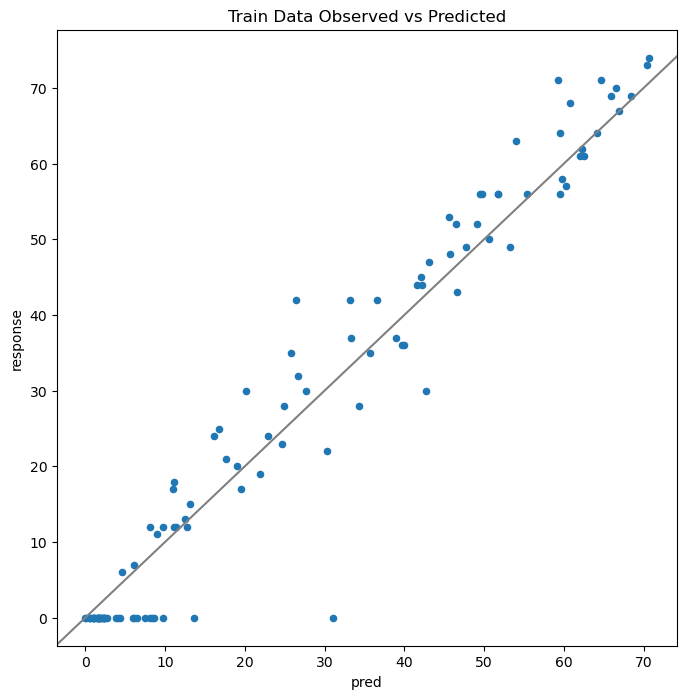

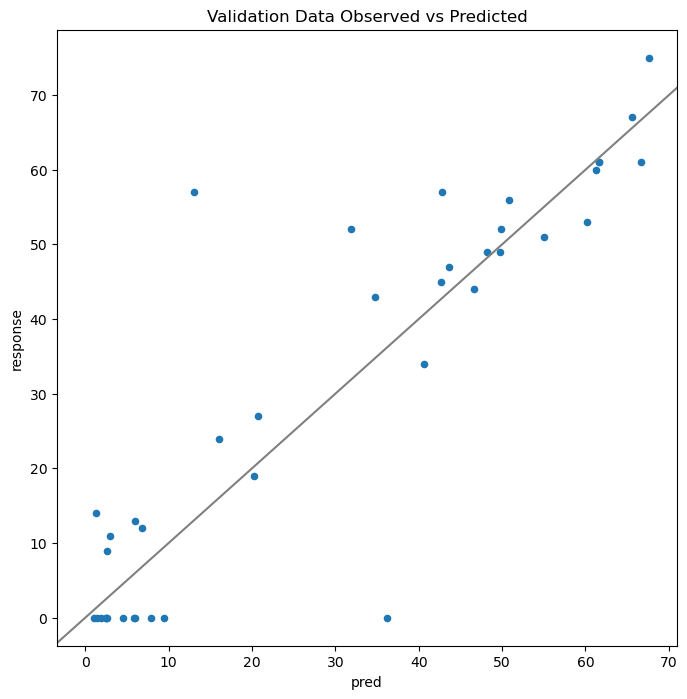

In [104]:
from sklearn.ensemble import RandomForestRegressor

reg2 = RandomForestRegressor(n_estimators=50,max_samples=0.75,random_state=0)
X=tdf_train[pred_ls].values
y=tdf_train['response'].values
reg2.fit(X,y)

pred=reg2.predict(tdf_val[pred_ls].values)
tdf_val['pred']=pred
tdf_train['pred']=reg2.predict(tdf_train[pred_ls].values)
#training dataset
print('Training Data')
print('Response std =',tdf_train['response'].std())
evdf=tdf_train[['response','pred']]
print('RMSE =',np.sqrt(((evdf['response']-evdf['pred'])**2).mean()))
print('train r2 =',(evdf.corr()).iloc[0,1]**2)
p = evdf.plot(kind='scatter',x='pred',y='response',title="Train Data Observed vs Predicted",figsize=(8,8))
p.axline((0, 0), slope=1,color='grey')
display(p)

#validation dataset
print('Response std =',tdf_val['response'].std())
evdf=tdf_val[['response','pred']]
print('RMSE =',np.sqrt(((evdf['response']-evdf['pred'])**2).mean()))
print('val r2 =',(evdf.corr()).iloc[0,1]**2)
p = evdf.plot(kind='scatter',x='pred',y='response',title="Validation Data Observed vs Predicted",figsize=(8,8))
p.axline((0, 0), slope=1,color='grey')
display(p)

Training Data
Response std = 25.234717999092936
RMSE = 11.748726762134583
train r2 = 0.7812485790108064


<Axes: title={'center': 'Train Data Observed vs Predicted'}, xlabel='pred', ylabel='response'>

Response std = 25.57180689142454
RMSE = 10.631111487752301
val r2 = 0.8282255112493941


<Axes: title={'center': 'Validation Data Observed vs Predicted'}, xlabel='pred', ylabel='response'>

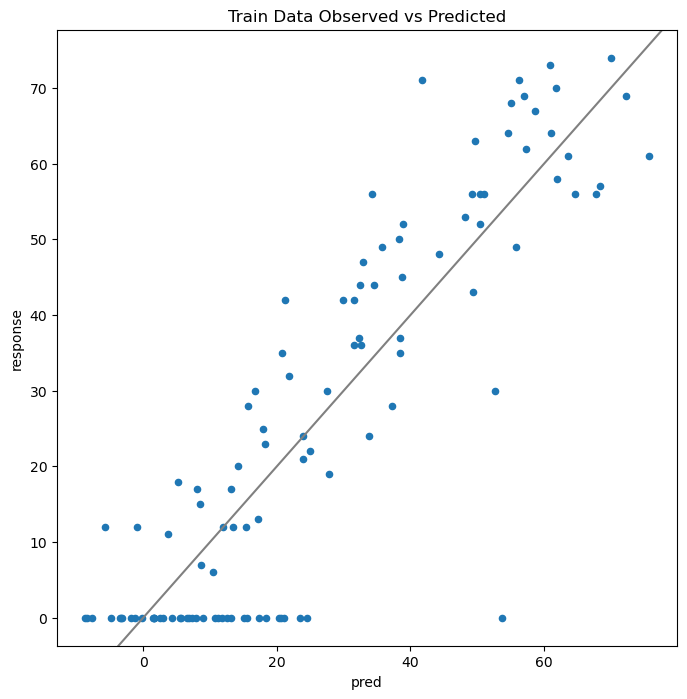

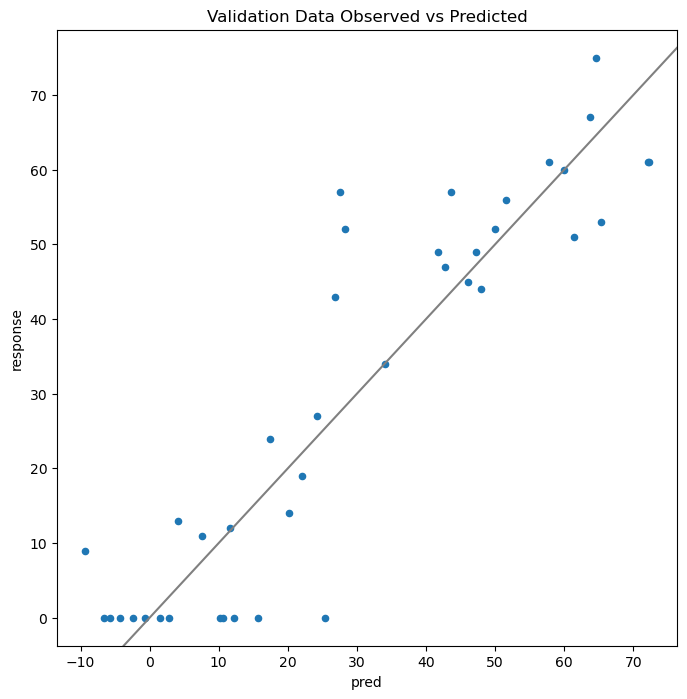

In [108]:
from sklearn.linear_model import LinearRegression

reg2 = LinearRegression().fit(X, y)

X=tdf_train[pred_ls].values
y=tdf_train['response'].values
reg2.fit(X,y)

pred=reg2.predict(tdf_val[pred_ls].values)
tdf_val['pred']=pred
tdf_train['pred']=reg2.predict(tdf_train[pred_ls].values)
#training dataset
print('Training Data')
print('Response std =',tdf_train['response'].std())
evdf=tdf_train[['response','pred']]
print('RMSE =',np.sqrt(((evdf['response']-evdf['pred'])**2).mean()))
print('train r2 =',(evdf.corr()).iloc[0,1]**2)
p = evdf.plot(kind='scatter',x='pred',y='response',title="Train Data Observed vs Predicted",figsize=(8,8))
p.axline((0, 0), slope=1,color='grey')
display(p)

#validation dataset
print('Response std =',tdf_val['response'].std())
evdf=tdf_val[['response','pred']]
print('RMSE =',np.sqrt(((evdf['response']-evdf['pred'])**2).mean()))
print('val r2 =',(evdf.corr()).iloc[0,1]**2)
p = evdf.plot(kind='scatter',x='pred',y='response',title="Validation Data Observed vs Predicted",figsize=(8,8))
p.axline((0, 0), slope=1,color='grey')
display(p)

In [ ]:
hc_rs=ls30s.model_predict(hc)
hc_rs.plot(robust=True,figsize=(15,8))